In [21]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("titanic")
df.head()



,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [22]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [23]:
df = df.drop(columns=["deck", "embark_town", "alive", "who", "adult_male", "class"])


In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_cols = ["age", "fare", "sibsp", "parch"]
categorical_cols = ["sex", "embarked"]


num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

 
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, categorical_cols)
])


In [25]:
from sklearn.model_selection import train_test_split

X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(model_pipeline):
    model_pipeline.fit(X_train, y_train)
    preds = model_pipeline.predict(X_test)
    probs = model_pipeline.predict_proba(X_test)[:,1]
    return {
        "accuracy": accuracy_score(y_test, preds),
        "f1":       f1_score(y_test, preds),
        "auc":      roc_auc_score(y_test, probs)
    }

models = {
    "LogisticRegression": Pipeline([("prep", preprocessor),
                                    ("clf", LogisticRegression(max_iter=1000))]),
    "KNN":                 Pipeline([("prep", preprocessor),
                                    ("clf", KNeighborsClassifier())]),
    "DecisionTree":        Pipeline([("prep", preprocessor),
                                    ("clf", DecisionTreeClassifier(random_state=42))])
}

baseline_results = {name: evaluate_model(pipe)
                    for name, pipe in models.items()}

baseline_results


{'LogisticRegression': {'accuracy': 0.7988826815642458,
  'f1': 0.71875,
  'auc': 0.8193675889328063},
 'KNN': {'accuracy': 0.8324022346368715,
  'f1': 0.7692307692307693,
  'auc': 0.8627140974967061},
 'DecisionTree': {'accuracy': 0.770949720670391,
  'f1': 0.7007299270072993,
  'auc': 0.7514492753623189}}

In [27]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "LogisticRegression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9],
        "clf__weights": ["uniform", "distance"]
    },
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    }
}

tuned_results = {}
for name, pipeline in models.items():
    gs = GridSearchCV(pipeline,
                      param_grids[name],
                      cv=5,
                      scoring="accuracy",
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    scores = evaluate_model(best)
    tuned_results[name] = {
        "best_params": gs.best_params_,
        **scores
    }

tuned_results


{'LogisticRegression': {'best_params': {'clf__C': 1},
  'accuracy': 0.7988826815642458,
  'f1': 0.71875,
  'auc': 0.8193675889328063},
 'KNN': {'best_params': {'clf__n_neighbors': 9, 'clf__weights': 'uniform'},
  'accuracy': 0.7821229050279329,
  'f1': 0.7111111111111111,
  'auc': 0.8381422924901186},
 'DecisionTree': {'best_params': {'clf__max_depth': 5,
   'clf__min_samples_split': 5},
  'accuracy': 0.8100558659217877,
  'f1': 0.734375,
  'auc': 0.8259552042160738}}

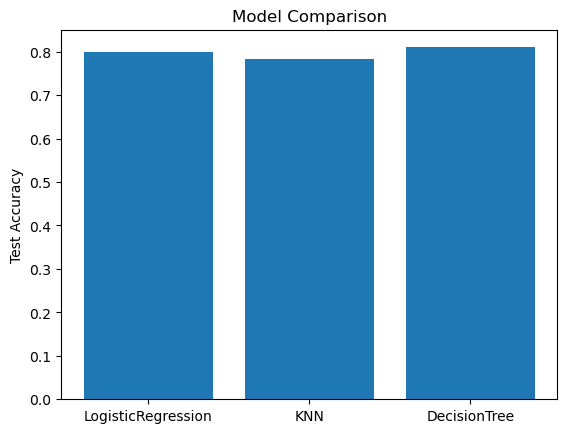

In [28]:
import matplotlib.pyplot as plt
names = list(baseline_results)
accs = [tuned_results[n]["accuracy"] for n in names]
plt.bar(names, accs)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison")
plt.show()


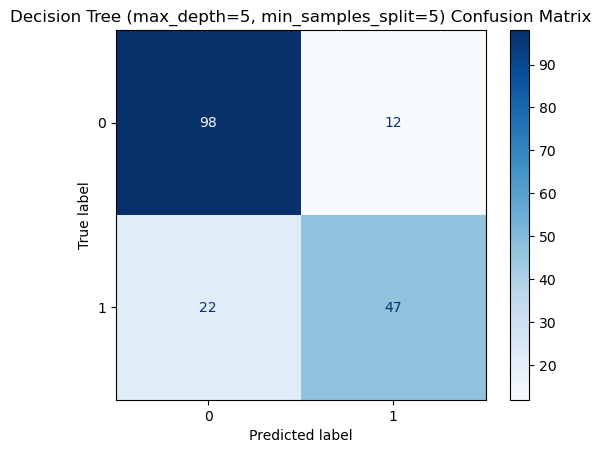

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10]
}
gs_dt = GridSearchCV(
    dt_pipe,
    dt_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
gs_dt.fit(X_train, y_train)


best_dt = gs_dt.best_estimator_

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=best_dt.named_steps["clf"].classes_)
disp.plot(cmap="Blues")
plt.title("Decision Tree (max_depth=%s, min_samples_split=%s) Confusion Matrix"
          % (gs_dt.best_params_["clf__max_depth"],
             gs_dt.best_params_["clf__min_samples_split"]))
plt.show()


In [8]:
import numpy as np, pandas as pd, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [12]:
def engineer(df):
    df = df.copy()
    df["family_size"] = df["sibsp"] + df["parch"] + 1
    df["is_alone"]    = (df["family_size"] == 1).astype(int)
    df["has_deck"]    = df["deck"].notna().astype(int)
    df["fare_per_person"] = df["fare"] / df["family_size"]
    return df.drop(columns=["alive","class","who","adult_male","embark_town"])

titanic = engineer(sns.load_dataset("titanic"))

In [14]:
from sklearn.model_selection import train_test_split

X = titanic.drop("survived", axis=1)
y = titanic["survived"]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(X_tr.shape, X_te.shape)


(712, 13) (179, 13)


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer([
    
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc" , StandardScaler())
    ]), num_cols),

   
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
])



In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import pandas as pd

models = {
    "LogReg":  LogisticRegression(max_iter=1000, random_state=42),
    "DecTree": DecisionTreeClassifier(max_depth=5, random_state=42)
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_tr, y_tr)

    y_pred = pipe.predict(X_te)
    y_prob = pipe.predict_proba(X_te)[:, 1]

    results[name] = {
        "accuracy":  accuracy_score(y_te, y_pred),
        "f1":        f1_score(y_te, y_pred),
        "roc_auc":   roc_auc_score(y_te, y_prob),
        "model":     pipe
    }

pd.DataFrame(results).T[["accuracy", "f1", "roc_auc"]]


,accuracy,f1,roc_auc
LogReg,0.821229,0.75,0.846377
DecTree,0.776536,0.677419,0.818906


In [19]:
 
tree = results["DecTree"]["model"].named_steps["clf"]
ohe  = results["DecTree"]["model"]\
        .named_steps["prep"]\
        .named_transformers_["cat"]\
        .named_steps["ohe"]

feat_names = (
    num_cols +
    list(ohe.get_feature_names_out(cat_cols))
)

importances = pd.Series(tree.feature_importances_, index=feat_names)\
                 .sort_values(ascending=False)
 
importances.head(10)


sex_male           0.508870
pclass             0.147070
age                0.125924
fare_per_person    0.113947
family_size        0.036979
fare               0.019961
embarked_S         0.016759
sibsp              0.010692
deck_D             0.009982
deck_E             0.009815
dtype: float64

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("clf" , RandomForestClassifier(
        n_estimators=300, max_depth=None,
        random_state=42, n_jobs=-1
    ))
])

rf_pipe.fit(X_tr, y_tr)
rf_prob = rf_pipe.predict_proba(X_te)[:, 1]

print("Random-Forest  ROC-AUC:",
      roc_auc_score(y_te, rf_prob))


Random-Forest  ROC-AUC: 0.8328063241106719


Brier_raw    0.152905
Brier_cal    0.152082
AUC_raw      0.832806
AUC_cal      0.829117
dtype: float64


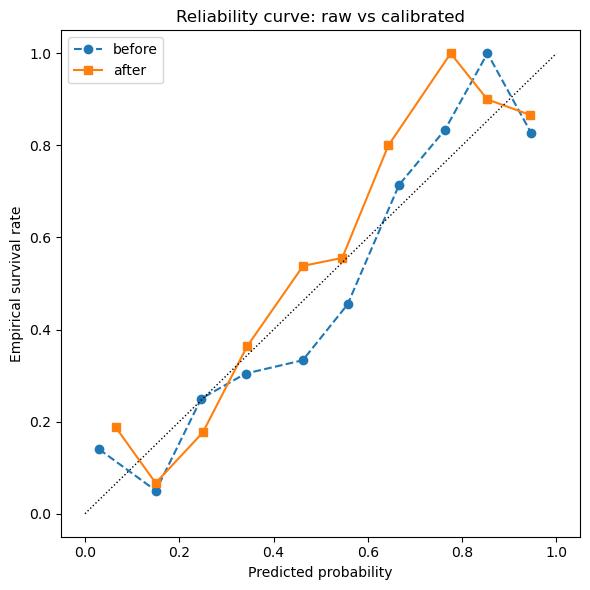

In [21]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

base_model = rf_pipe

cal = CalibratedClassifierCV(estimator=base_model, method="isotonic", cv=5)
cal.fit(X_tr, y_tr)

p_raw = base_model.predict_proba(X_te)[:, 1]
p_cal = cal.predict_proba(X_te)[:, 1]

metrics = {
    "Brier_raw": brier_score_loss(y_te, p_raw),
    "Brier_cal": brier_score_loss(y_te, p_cal),
    "AUC_raw": roc_auc_score(y_te, p_raw),
    "AUC_cal": roc_auc_score(y_te, p_cal),
}
print(pd.Series(metrics))

fig, ax = plt.subplots(figsize=(6, 6))
for probs, label, style in [
    (p_raw, "before", dict(ls="--", marker="o")),
    (p_cal, "after", dict(ls="-", marker="s"))
]:
    frac_pos, mean_pred = calibration_curve(y_te, probs, n_bins=10, strategy="uniform")
    ax.plot(mean_pred, frac_pos, label=label, **style)

ax.plot([0, 1], [0, 1], "k:", lw=1)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Empirical survival rate")
ax.set_title("Reliability curve: raw vs calibrated")
ax.legend()
plt.tight_layout()
plt.show()
